# Packages

In [1]:
!pip install torchmetrics tqdm --upgrade

# Imports

In [1]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader, random_split

from torchmetrics.text import Perplexity

import tqdm

from collections import Counter

2023-10-13 01:21:34.126336: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-13 01:21:34.791879: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Configuration

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
seq_len = 25
batch_size = 25
min_freq = 0

num_epochs = 100

max_lr_dec = 3
lr_dec = 0


# Utils

In [4]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [3]:
def num_trainable_params(model):
  nums = sum(p.numel() for p in model.parameters() if p.requires_grad)/1e6
  return nums

# Dataset

## Download Dataset

In [26]:
char2ind = {}
def data_init():
    global char2ind
    with open("../../../Datasets/penn/train.txt", encoding="utf8") as f:
        file = f.read()
        trn = file[1:].split(' ')
    with open("../../../Datasets/penn/valid.txt", encoding="utf8") as f:
        file = f.read()
        vld = file[1:].split(' ')
    with open("../../../Datasets/penn/test.txt", encoding="utf8") as f:
        file = f.read()
        tst = file[1:].split(' ')
    words = sorted(set(trn))
    char2ind = {c: i for i, c in enumerate(words)}
    trn = [char2ind[c] for c in trn]
    vld = [char2ind[c] for c in vld]
    tst = [char2ind[c] for c in tst]
    return torch.tensor(trn,dtype=torch.int64), torch.tensor(vld,dtype=torch.int64), torch.tensor(tst,dtype=torch.int64), len(words)

def findWordByToken(iToken):
    for word, toekn in char2ind.items():  # for name, age in dictionary.iteritems():  (for Python 2.x)
        if toekn == iToken:
            return word
    return ''

## Custom Dataset

In [27]:
class Wikitext2Dataset(Dataset):
  def __init__(self, tokens, seq_len):
    self.tokens = tokens
    self.seq_len = seq_len
  def __len__(self):
    return  len(self.tokens) // self.seq_len

  def __getitem__(self, idx):
    start_idx = idx * self.seq_len
    end_idx = start_idx + self.seq_len
    input = self.tokens[start_idx:end_idx]
    target = self.tokens[start_idx+1:end_idx+1]
    return torch.tensor(input), torch.tensor(target)

In [28]:
train_tokens_voc , valid_tokens_voc , test_tokens_voc , vocab_size= data_init()

# Datasets
train_dataset = Wikitext2Dataset(train_tokens_voc, seq_len)
valid_dataset = Wikitext2Dataset(valid_tokens_voc, seq_len)
test_dataset = Wikitext2Dataset(test_tokens_voc, seq_len)

# Dataloaders
train_loader = DataLoader(train_dataset , batch_size )
valid_loader = DataLoader(valid_dataset , batch_size )
test_loader = DataLoader(test_dataset , batch_size )

# Model

In [29]:
class H_LSTM(nn.Module):

  def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, dropout_rate):
    super().__init__()
    self.vocab_size = vocab_size
    
    #Embedding Layer
    self.embedding = nn.Embedding(vocab_size, embedding_dim)
    self.dropout_em = nn.Dropout(0.1)
    
    # Layer 1
    self.rnn1 = nn.LSTM(input_size=embedding_dim,
                      hidden_size=hidden_dim,
                      num_layers=num_layers,
                      bidirectional=False,
                      batch_first=True)
    self.dropout1 = nn.Dropout(dropout_rate)
    
    # Layer 2
    self.rnn2 = nn.LSTM(input_size=hidden_dim,
                      hidden_size=hidden_dim,
                      num_layers=num_layers,
                      bidirectional=False,
                      batch_first=True)
    self.dropout2 = nn.Dropout(dropout_rate)
    
    # Layer 3
    self.rnn3 = nn.LSTM(input_size=hidden_dim,
                      hidden_size=hidden_dim,
                      num_layers=1,
                      bidirectional=False,
                      batch_first=True)
    self.dropout3 = nn.Dropout(dropout_rate)
    
    self.fc = nn.Linear(hidden_dim,vocab_size,bias=True)

  def forward(self, src):
    embedding = self.dropout_em( self.embedding(src) )
    
    output, (h,c) = self.rnn1(embedding)
    output = self.dropout1(output)
    
    output, (h,c) = self.rnn2(output,(c,h))
    output = self.dropout2(output)
    
    output, (h,c) = self.rnn3(output,(c,h))
    output = self.dropout3(output)
    
    output = self.fc(output)
    return output

# Train

## Learning Functions

In [30]:
def train_one_epoch(model, train_loader, loss_fn, optimizer, perp , epoch=1):
  
  global seq_len
  global batch_size
  
  model.train()
  loss_train = AverageMeter()
  perplexity_train = AverageMeter()
    
  with tqdm.tqdm(train_loader, unit='batch') as tepoch:
    for inputs, targets in tepoch:

      tepoch.set_description(f'Epoch {epoch}')

      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)

      batch_size, seq_len, vocab_size = outputs.size()
      outputs = outputs.view(batch_size * seq_len, vocab_size)
      targets = targets.view(-1)
      
      loss = loss_fn(outputs, targets)
      
      loss.backward()
      
      perplexity = perp(outputs.view(batch_size, seq_len, vocab_size), targets.view(batch_size, seq_len))
      
      optimizer.step()
      optimizer.zero_grad()

      loss_train.update(loss.item(), n=len(targets))
      perplexity_train.update(perplexity.item(), n=len(targets))

      tepoch.set_postfix(loss=loss_train.avg, perplexity = perplexity_train.avg )
      
      del inputs
      del targets
      del outputs

  return model, loss_train.avg, perplexity_train.avg 

In [31]:
def evaluate(model, test_loader, loss_fn , perp ):
  
  global seq_len
  global batch_size
  
  model.eval()
  loss_eval = AverageMeter()
  perplexity_eval = AverageMeter()

  with torch.inference_mode():
    for inputs, targets in test_loader:
      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)
      
      batch_size, seq_len, vocab_size = outputs.size()
      outputs = outputs.view(batch_size * seq_len, vocab_size)
      targets = targets.view(-1)

      loss = loss_fn(outputs, targets)
      
      perplexity = perp(outputs.view(batch_size, seq_len, vocab_size), targets.view(batch_size, seq_len))

      loss_eval.update(loss.item(), n=len(targets))
      perplexity_eval.update(perplexity.item(), n=len(targets))
      
      del inputs
      del targets
      del outputs

  return loss_eval.avg,perplexity_eval.avg

## Parameters

In [17]:
embedding_dim = 500
hidden_dim = 500
num_layers = 1
dropout_rate = 0.25

model = H_LSTM( vocab_size, embedding_dim=embedding_dim, hidden_dim=hidden_dim , num_layers=num_layers, dropout_rate= dropout_rate )
model = model.to(device)

loss_train_hist = []
loss_valid_hist = []

per_train_hist = []
per_valid_hist = []

lr_train_hist = []

best_perplexity_valid = torch.inf
epoch_counter = 0

model

H_LSTM(
  (embedding): Embedding(10000, 500)
  (dropout_em): Dropout(p=0.1, inplace=False)
  (rnn1): LSTM(500, 500, batch_first=True)
  (dropout1): Dropout(p=0.25, inplace=False)
  (rnn2): LSTM(500, 500, batch_first=True)
  (dropout2): Dropout(p=0.25, inplace=False)
  (rnn3): LSTM(500, 500, batch_first=True)
  (dropout3): Dropout(p=0.25, inplace=False)
  (fc): Linear(in_features=500, out_features=10000, bias=True)
)

In [18]:
num_trainable_params(model)

16.022

## Learning Loop

In [19]:

lr = 0.5
wd = 1e-5
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd, momentum=0.9)
loss_fn = nn.CrossEntropyLoss()  
perp = Perplexity().to(device)

In [20]:
num_epochs = 300
max_lr_dec = 5
lr_dec = 0

for epoch in range(num_epochs):
  # Train
  model, loss_train, per_train = train_one_epoch(model, train_loader, loss_fn, optimizer, perp , epoch)
  # Validation
  loss_valid, per_val = evaluate(model, valid_loader, loss_fn, perp)

  loss_train_hist.append(loss_train)
  loss_valid_hist.append(loss_valid)

  per_train_hist.append(per_train)
  per_valid_hist.append(per_val)

  lr_train_hist.append(lr)
  
  print(f'Valid: Loss = {loss_valid:.4} Perplexity= {per_val:.4}, LR = {lr}')
  epoch_counter += 1
  
  if per_val < best_perplexity_valid:
    lr_dec = 0
    torch.save(model, f'model.pt')
    best_perplexity_valid = per_val
    print('Model Saved!')
  else:
    if lr_dec >= max_lr_dec :
      print("LR_DEC==3 , Finished")
      break
    lr_dec += 1
    
    del model
    del perp
    del loss_fn
    del optimizer
    
    model_path = 'model.pt'
    model = torch.load(model_path,map_location=device)
    lr /= 2
    optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd, momentum=0.9)
    loss_fn = nn.CrossEntropyLoss()
    perp = Perplexity().to(device)
  print()
  

  0%|          | 0/1488 [00:00<?, ?batch/s]/tmp/ipykernel_4679/1059837893.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(input), torch.tensor(target)
Epoch 0: 100%|██████████| 1488/1488 [00:20<00:00, 71.68batch/s, loss=6.06, perplexity=542]   


Valid: Loss = 5.524 Perplexity= 270.4, LR = 0.5
Model Saved!



Epoch 1: 100%|██████████| 1488/1488 [00:20<00:00, 73.57batch/s, loss=5.36, perplexity=232]


Valid: Loss = 5.114 Perplexity= 182.7, LR = 0.5
Model Saved!



Epoch 2: 100%|██████████| 1488/1488 [00:20<00:00, 73.70batch/s, loss=4.99, perplexity=160]


Valid: Loss = 4.797 Perplexity= 134.0, LR = 0.5
Model Saved!



Epoch 3: 100%|██████████| 1488/1488 [00:20<00:00, 73.95batch/s, loss=4.67, perplexity=117]


Valid: Loss = 4.516 Perplexity= 101.2, LR = 0.5
Model Saved!



Epoch 4: 100%|██████████| 1488/1488 [00:20<00:00, 72.88batch/s, loss=4.37, perplexity=86.5]


Valid: Loss = 4.229 Perplexity= 76.07, LR = 0.5
Model Saved!



Epoch 5: 100%|██████████| 1488/1488 [00:20<00:00, 73.66batch/s, loss=4.09, perplexity=66]  


Valid: Loss = 4.031 Perplexity= 62.4, LR = 0.5
Model Saved!



Epoch 6: 100%|██████████| 1488/1488 [00:20<00:00, 73.40batch/s, loss=3.87, perplexity=52.5]


Valid: Loss = 3.837 Perplexity= 51.15, LR = 0.5
Model Saved!



Epoch 7: 100%|██████████| 1488/1488 [00:20<00:00, 74.19batch/s, loss=3.68, perplexity=43.2]


Valid: Loss = 3.686 Perplexity= 44.0, LR = 0.5
Model Saved!



Epoch 8: 100%|██████████| 1488/1488 [00:20<00:00, 73.54batch/s, loss=3.51, perplexity=36.4]


Valid: Loss = 3.544 Perplexity= 38.15, LR = 0.5
Model Saved!



Epoch 9: 100%|██████████| 1488/1488 [00:19<00:00, 74.40batch/s, loss=3.38, perplexity=31.9]


Valid: Loss = 3.453 Perplexity= 34.82, LR = 0.5
Model Saved!



Epoch 10: 100%|██████████| 1488/1488 [00:20<00:00, 74.17batch/s, loss=3.23, perplexity=27.4]


Valid: Loss = 3.294 Perplexity= 29.59, LR = 0.5
Model Saved!



Epoch 11: 100%|██████████| 1488/1488 [00:20<00:00, 74.38batch/s, loss=3.07, perplexity=23.5]


Valid: Loss = 3.186 Perplexity= 26.5, LR = 0.5
Model Saved!



Epoch 12: 100%|██████████| 1488/1488 [00:20<00:00, 73.97batch/s, loss=2.94, perplexity=20.4]


Valid: Loss = 3.07 Perplexity= 23.54, LR = 0.5
Model Saved!



Epoch 13: 100%|██████████| 1488/1488 [00:20<00:00, 73.43batch/s, loss=2.82, perplexity=18.1]


Valid: Loss = 2.94 Perplexity= 20.63, LR = 0.5
Model Saved!



Epoch 14: 100%|██████████| 1488/1488 [00:20<00:00, 72.62batch/s, loss=2.7, perplexity=15.9] 


Valid: Loss = 2.829 Perplexity= 18.42, LR = 0.5
Model Saved!



Epoch 15: 100%|██████████| 1488/1488 [00:19<00:00, 74.63batch/s, loss=2.63, perplexity=14.9]


Valid: Loss = 2.79 Perplexity= 17.72, LR = 0.5
Model Saved!



Epoch 16: 100%|██████████| 1488/1488 [00:20<00:00, 73.93batch/s, loss=2.52, perplexity=13.3]


Valid: Loss = 2.693 Perplexity= 16.02, LR = 0.5
Model Saved!



Epoch 17: 100%|██████████| 1488/1488 [00:20<00:00, 74.30batch/s, loss=2.41, perplexity=11.8]


Valid: Loss = 2.611 Perplexity= 14.76, LR = 0.5
Model Saved!



Epoch 18: 100%|██████████| 1488/1488 [00:20<00:00, 74.29batch/s, loss=2.31, perplexity=10.6]


Valid: Loss = 2.511 Perplexity= 13.3, LR = 0.5
Model Saved!



Epoch 19: 100%|██████████| 1488/1488 [00:19<00:00, 74.43batch/s, loss=2.22, perplexity=9.71]


Valid: Loss = 2.423 Perplexity= 12.2, LR = 0.5
Model Saved!



Epoch 20: 100%|██████████| 1488/1488 [00:20<00:00, 74.33batch/s, loss=2.14, perplexity=8.95]


Valid: Loss = 2.358 Perplexity= 11.4, LR = 0.5
Model Saved!



Epoch 21: 100%|██████████| 1488/1488 [00:19<00:00, 74.73batch/s, loss=2.06, perplexity=8.24]


Valid: Loss = 2.279 Perplexity= 10.51, LR = 0.5
Model Saved!



Epoch 22: 100%|██████████| 1488/1488 [00:20<00:00, 74.11batch/s, loss=1.98, perplexity=7.63]


Valid: Loss = 2.218 Perplexity= 9.867, LR = 0.5
Model Saved!



Epoch 23: 100%|██████████| 1488/1488 [00:19<00:00, 74.54batch/s, loss=1.91, perplexity=7.1] 


Valid: Loss = 2.168 Perplexity= 9.357, LR = 0.5
Model Saved!



Epoch 24: 100%|██████████| 1488/1488 [00:20<00:00, 74.13batch/s, loss=1.85, perplexity=6.63]


Valid: Loss = 2.122 Perplexity= 8.912, LR = 0.5
Model Saved!



Epoch 25: 100%|██████████| 1488/1488 [00:19<00:00, 74.87batch/s, loss=1.8, perplexity=6.29] 


Valid: Loss = 2.049 Perplexity= 8.262, LR = 0.5
Model Saved!



Epoch 26: 100%|██████████| 1488/1488 [00:20<00:00, 74.16batch/s, loss=1.74, perplexity=5.9] 


Valid: Loss = 1.994 Perplexity= 7.798, LR = 0.5
Model Saved!



Epoch 27: 100%|██████████| 1488/1488 [00:20<00:00, 71.11batch/s, loss=1.67, perplexity=5.51]


Valid: Loss = 1.951 Perplexity= 7.496, LR = 0.5
Model Saved!



Epoch 28: 100%|██████████| 1488/1488 [00:20<00:00, 72.31batch/s, loss=1.61, perplexity=5.2] 


Valid: Loss = 1.908 Perplexity= 7.163, LR = 0.5
Model Saved!



Epoch 29: 100%|██████████| 1488/1488 [00:20<00:00, 73.13batch/s, loss=1.57, perplexity=4.95]


Valid: Loss = 1.874 Perplexity= 6.923, LR = 0.5
Model Saved!



Epoch 30: 100%|██████████| 1488/1488 [00:20<00:00, 72.29batch/s, loss=1.53, perplexity=4.77]


Valid: Loss = 1.816 Perplexity= 6.494, LR = 0.5
Model Saved!



Epoch 31: 100%|██████████| 1488/1488 [00:20<00:00, 73.36batch/s, loss=1.5, perplexity=4.6]  


Valid: Loss = 1.778 Perplexity= 6.247, LR = 0.5
Model Saved!



Epoch 32: 100%|██████████| 1488/1488 [00:20<00:00, 74.27batch/s, loss=1.48, perplexity=4.54]


Valid: Loss = 1.764 Perplexity= 6.162, LR = 0.5
Model Saved!



Epoch 33: 100%|██████████| 1488/1488 [00:20<00:00, 72.43batch/s, loss=1.42, perplexity=4.23]


Valid: Loss = 1.732 Perplexity= 5.959, LR = 0.5
Model Saved!



Epoch 34: 100%|██████████| 1488/1488 [00:20<00:00, 72.75batch/s, loss=1.37, perplexity=4.05]


Valid: Loss = 1.677 Perplexity= 5.633, LR = 0.5
Model Saved!



Epoch 35: 100%|██████████| 1488/1488 [00:20<00:00, 73.00batch/s, loss=1.34, perplexity=3.92]


Valid: Loss = 1.647 Perplexity= 5.455, LR = 0.5
Model Saved!



Epoch 36: 100%|██████████| 1488/1488 [00:20<00:00, 72.77batch/s, loss=1.31, perplexity=3.81]


Valid: Loss = 1.621 Perplexity= 5.319, LR = 0.5
Model Saved!



Epoch 37: 100%|██████████| 1488/1488 [00:20<00:00, 72.42batch/s, loss=1.27, perplexity=3.65]


Valid: Loss = 1.593 Perplexity= 5.172, LR = 0.5
Model Saved!



Epoch 38: 100%|██████████| 1488/1488 [00:20<00:00, 72.67batch/s, loss=1.25, perplexity=3.56]


Valid: Loss = 1.56 Perplexity= 4.993, LR = 0.5
Model Saved!



Epoch 39: 100%|██████████| 1488/1488 [00:20<00:00, 72.76batch/s, loss=1.21, perplexity=3.43]


Valid: Loss = 1.521 Perplexity= 4.792, LR = 0.5
Model Saved!



Epoch 40: 100%|██████████| 1488/1488 [00:20<00:00, 73.37batch/s, loss=1.19, perplexity=3.35]


Valid: Loss = 1.474 Perplexity= 4.563, LR = 0.5
Model Saved!



Epoch 41: 100%|██████████| 1488/1488 [00:20<00:00, 72.61batch/s, loss=1.18, perplexity=3.31]


Valid: Loss = 1.487 Perplexity= 4.622, LR = 0.5



Epoch 42: 100%|██████████| 1488/1488 [00:20<00:00, 73.13batch/s, loss=0.841, perplexity=2.36]


Valid: Loss = 1.163 Perplexity= 3.309, LR = 0.25
Model Saved!



Epoch 43: 100%|██████████| 1488/1488 [00:20<00:00, 72.63batch/s, loss=0.745, perplexity=2.13]


Valid: Loss = 1.128 Perplexity= 3.196, LR = 0.25
Model Saved!



Epoch 44: 100%|██████████| 1488/1488 [00:20<00:00, 73.07batch/s, loss=0.71, perplexity=2.05] 


Valid: Loss = 1.098 Perplexity= 3.093, LR = 0.25
Model Saved!



Epoch 45: 100%|██████████| 1488/1488 [00:20<00:00, 74.17batch/s, loss=0.689, perplexity=2.01]


Valid: Loss = 1.077 Perplexity= 3.028, LR = 0.25
Model Saved!



Epoch 46: 100%|██████████| 1488/1488 [00:20<00:00, 73.56batch/s, loss=0.675, perplexity=1.98]


Valid: Loss = 1.064 Perplexity= 2.984, LR = 0.25
Model Saved!



Epoch 47: 100%|██████████| 1488/1488 [00:20<00:00, 72.93batch/s, loss=0.665, perplexity=1.96]


Valid: Loss = 1.055 Perplexity= 2.955, LR = 0.25
Model Saved!



Epoch 48: 100%|██████████| 1488/1488 [00:20<00:00, 74.10batch/s, loss=0.657, perplexity=1.94]


Valid: Loss = 1.042 Perplexity= 2.915, LR = 0.25
Model Saved!



Epoch 49: 100%|██████████| 1488/1488 [00:20<00:00, 73.08batch/s, loss=0.652, perplexity=1.93]


Valid: Loss = 1.037 Perplexity= 2.903, LR = 0.25
Model Saved!



Epoch 50: 100%|██████████| 1488/1488 [00:20<00:00, 73.28batch/s, loss=0.644, perplexity=1.92]


Valid: Loss = 1.039 Perplexity= 2.909, LR = 0.25



Epoch 51: 100%|██████████| 1488/1488 [00:19<00:00, 74.89batch/s, loss=0.498, perplexity=1.65]


Valid: Loss = 0.8762 Perplexity= 2.46, LR = 0.125
Model Saved!



Epoch 52: 100%|██████████| 1488/1488 [00:20<00:00, 73.65batch/s, loss=0.458, perplexity=1.59]


Valid: Loss = 0.8583 Perplexity= 2.413, LR = 0.125
Model Saved!



Epoch 53: 100%|██████████| 1488/1488 [00:20<00:00, 74.13batch/s, loss=0.442, perplexity=1.56]


Valid: Loss = 0.8468 Perplexity= 2.384, LR = 0.125
Model Saved!



Epoch 54: 100%|██████████| 1488/1488 [00:19<00:00, 75.53batch/s, loss=0.433, perplexity=1.55]


Valid: Loss = 0.8374 Perplexity= 2.362, LR = 0.125
Model Saved!



Epoch 55: 100%|██████████| 1488/1488 [00:19<00:00, 75.15batch/s, loss=0.427, perplexity=1.54]


Valid: Loss = 0.8291 Perplexity= 2.34, LR = 0.125
Model Saved!



Epoch 56: 100%|██████████| 1488/1488 [00:19<00:00, 74.45batch/s, loss=0.423, perplexity=1.53]


Valid: Loss = 0.8306 Perplexity= 2.344, LR = 0.125



Epoch 57: 100%|██████████| 1488/1488 [00:20<00:00, 74.33batch/s, loss=0.371, perplexity=1.45]


Valid: Loss = 0.7622 Perplexity= 2.184, LR = 0.0625
Model Saved!



Epoch 58: 100%|██████████| 1488/1488 [00:20<00:00, 73.66batch/s, loss=0.354, perplexity=1.43]


Valid: Loss = 0.7525 Perplexity= 2.162, LR = 0.0625
Model Saved!



Epoch 59: 100%|██████████| 1488/1488 [00:20<00:00, 74.30batch/s, loss=0.346, perplexity=1.42]


Valid: Loss = 0.7471 Perplexity= 2.15, LR = 0.0625
Model Saved!



Epoch 60: 100%|██████████| 1488/1488 [00:20<00:00, 74.25batch/s, loss=0.341, perplexity=1.41]


Valid: Loss = 0.7435 Perplexity= 2.142, LR = 0.0625
Model Saved!



Epoch 61: 100%|██████████| 1488/1488 [00:19<00:00, 75.17batch/s, loss=0.337, perplexity=1.4] 


Valid: Loss = 0.7388 Perplexity= 2.131, LR = 0.0625
Model Saved!



Epoch 62: 100%|██████████| 1488/1488 [00:20<00:00, 74.26batch/s, loss=0.333, perplexity=1.4] 


Valid: Loss = 0.7342 Perplexity= 2.121, LR = 0.0625
Model Saved!



Epoch 63: 100%|██████████| 1488/1488 [00:19<00:00, 74.93batch/s, loss=0.331, perplexity=1.39]


Valid: Loss = 0.7357 Perplexity= 2.125, LR = 0.0625



Epoch 64: 100%|██████████| 1488/1488 [00:20<00:00, 74.39batch/s, loss=0.31, perplexity=1.37] 


Valid: Loss = 0.7072 Perplexity= 2.062, LR = 0.03125
Model Saved!



Epoch 65: 100%|██████████| 1488/1488 [00:19<00:00, 74.74batch/s, loss=0.303, perplexity=1.36]


Valid: Loss = 0.703 Perplexity= 2.054, LR = 0.03125
Model Saved!



Epoch 66: 100%|██████████| 1488/1488 [00:20<00:00, 74.15batch/s, loss=0.299, perplexity=1.35]


Valid: Loss = 0.7024 Perplexity= 2.052, LR = 0.03125
Model Saved!



Epoch 67: 100%|██████████| 1488/1488 [00:19<00:00, 75.01batch/s, loss=0.296, perplexity=1.35]


Valid: Loss = 0.6985 Perplexity= 2.043, LR = 0.03125
Model Saved!



Epoch 68: 100%|██████████| 1488/1488 [00:20<00:00, 73.61batch/s, loss=0.293, perplexity=1.34]


Valid: Loss = 0.6933 Perplexity= 2.033, LR = 0.03125
Model Saved!



Epoch 69: 100%|██████████| 1488/1488 [00:20<00:00, 74.02batch/s, loss=0.291, perplexity=1.34]


Valid: Loss = 0.6922 Perplexity= 2.031, LR = 0.03125
Model Saved!



Epoch 70: 100%|██████████| 1488/1488 [00:19<00:00, 75.61batch/s, loss=0.289, perplexity=1.34]


Valid: Loss = 0.6908 Perplexity= 2.028, LR = 0.03125
Model Saved!



Epoch 71: 100%|██████████| 1488/1488 [00:20<00:00, 74.28batch/s, loss=0.288, perplexity=1.34]


Valid: Loss = 0.6905 Perplexity= 2.027, LR = 0.03125
Model Saved!



Epoch 72: 100%|██████████| 1488/1488 [00:19<00:00, 74.60batch/s, loss=0.286, perplexity=1.33]


Valid: Loss = 0.689 Perplexity= 2.023, LR = 0.03125
Model Saved!



Epoch 73: 100%|██████████| 1488/1488 [00:20<00:00, 74.25batch/s, loss=0.284, perplexity=1.33]


Valid: Loss = 0.6953 Perplexity= 2.037, LR = 0.03125



Epoch 74: 100%|██████████| 1488/1488 [00:19<00:00, 74.42batch/s, loss=0.275, perplexity=1.32]


Valid: Loss = 0.6769 Perplexity= 1.998, LR = 0.015625
Model Saved!



Epoch 75: 100%|██████████| 1488/1488 [00:20<00:00, 73.85batch/s, loss=0.271, perplexity=1.31]


Valid: Loss = 0.6755 Perplexity= 1.995, LR = 0.015625
Model Saved!



Epoch 76: 100%|██████████| 1488/1488 [00:19<00:00, 75.41batch/s, loss=0.27, perplexity=1.31] 


Valid: Loss = 0.6757 Perplexity= 1.996, LR = 0.015625



Epoch 77: 100%|██████████| 1488/1488 [00:19<00:00, 75.87batch/s, loss=0.265, perplexity=1.31]


Valid: Loss = 0.6721 Perplexity= 1.988, LR = 0.0078125
Model Saved!



Epoch 78: 100%|██████████| 1488/1488 [00:19<00:00, 75.18batch/s, loss=0.264, perplexity=1.3] 


Valid: Loss = 0.6696 Perplexity= 1.983, LR = 0.0078125
Model Saved!



Epoch 79: 100%|██████████| 1488/1488 [00:20<00:00, 71.77batch/s, loss=0.263, perplexity=1.3] 


Valid: Loss = 0.6696 Perplexity= 1.983, LR = 0.0078125



Epoch 80: 100%|██████████| 1488/1488 [00:20<00:00, 73.93batch/s, loss=0.261, perplexity=1.3] 


Valid: Loss = 0.6668 Perplexity= 1.978, LR = 0.00390625
Model Saved!



Epoch 81: 100%|██████████| 1488/1488 [00:19<00:00, 75.51batch/s, loss=0.259, perplexity=1.3]


Valid: Loss = 0.6659 Perplexity= 1.976, LR = 0.00390625
Model Saved!



Epoch 82: 100%|██████████| 1488/1488 [00:19<00:00, 75.30batch/s, loss=0.258, perplexity=1.3]


Valid: Loss = 0.6655 Perplexity= 1.975, LR = 0.00390625
Model Saved!



Epoch 83: 100%|██████████| 1488/1488 [00:19<00:00, 74.94batch/s, loss=0.258, perplexity=1.3]


Valid: Loss = 0.665 Perplexity= 1.974, LR = 0.00390625
Model Saved!



Epoch 84: 100%|██████████| 1488/1488 [00:19<00:00, 74.82batch/s, loss=0.257, perplexity=1.3]


Valid: Loss = 0.6641 Perplexity= 1.972, LR = 0.00390625
Model Saved!



Epoch 85: 100%|██████████| 1488/1488 [00:20<00:00, 74.03batch/s, loss=0.258, perplexity=1.3]


Valid: Loss = 0.664 Perplexity= 1.972, LR = 0.00390625
Model Saved!



Epoch 86: 100%|██████████| 1488/1488 [00:19<00:00, 74.55batch/s, loss=0.257, perplexity=1.29]


Valid: Loss = 0.6641 Perplexity= 1.972, LR = 0.00390625



Epoch 87: 100%|██████████| 1488/1488 [00:20<00:00, 74.34batch/s, loss=0.256, perplexity=1.29]


Valid: Loss = 0.663 Perplexity= 1.97, LR = 0.001953125
Model Saved!



Epoch 88: 100%|██████████| 1488/1488 [00:19<00:00, 75.61batch/s, loss=0.255, perplexity=1.29]


Valid: Loss = 0.6632 Perplexity= 1.97, LR = 0.001953125



Epoch 89: 100%|██████████| 1488/1488 [00:19<00:00, 74.94batch/s, loss=0.255, perplexity=1.29]


Valid: Loss = 0.6624 Perplexity= 1.968, LR = 0.0009765625
Model Saved!



Epoch 90: 100%|██████████| 1488/1488 [00:19<00:00, 76.18batch/s, loss=0.254, perplexity=1.29]


Valid: Loss = 0.6625 Perplexity= 1.969, LR = 0.0009765625



Epoch 91: 100%|██████████| 1488/1488 [00:19<00:00, 75.35batch/s, loss=0.254, perplexity=1.29]


Valid: Loss = 0.662 Perplexity= 1.968, LR = 0.00048828125
Model Saved!



Epoch 92: 100%|██████████| 1488/1488 [00:19<00:00, 74.96batch/s, loss=0.254, perplexity=1.29]


Valid: Loss = 0.6617 Perplexity= 1.967, LR = 0.00048828125
Model Saved!



Epoch 93: 100%|██████████| 1488/1488 [00:19<00:00, 75.36batch/s, loss=0.254, perplexity=1.29]


Valid: Loss = 0.6614 Perplexity= 1.966, LR = 0.00048828125
Model Saved!



Epoch 94: 100%|██████████| 1488/1488 [00:19<00:00, 75.07batch/s, loss=0.254, perplexity=1.29]


Valid: Loss = 0.6616 Perplexity= 1.967, LR = 0.00048828125



Epoch 95: 100%|██████████| 1488/1488 [00:19<00:00, 75.29batch/s, loss=0.254, perplexity=1.29]


Valid: Loss = 0.6609 Perplexity= 1.965, LR = 0.000244140625
Model Saved!



Epoch 96: 100%|██████████| 1488/1488 [00:19<00:00, 76.90batch/s, loss=0.254, perplexity=1.29]


Valid: Loss = 0.661 Perplexity= 1.966, LR = 0.000244140625



Epoch 97: 100%|██████████| 1488/1488 [00:20<00:00, 74.01batch/s, loss=0.254, perplexity=1.29]


Valid: Loss = 0.6607 Perplexity= 1.965, LR = 0.0001220703125
Model Saved!



Epoch 98: 100%|██████████| 1488/1488 [00:19<00:00, 74.78batch/s, loss=0.253, perplexity=1.29]


Valid: Loss = 0.6607 Perplexity= 1.965, LR = 0.0001220703125
Model Saved!



Epoch 99: 100%|██████████| 1488/1488 [00:20<00:00, 74.18batch/s, loss=0.254, perplexity=1.29]


Valid: Loss = 0.6606 Perplexity= 1.965, LR = 0.0001220703125
Model Saved!



Epoch 100: 100%|██████████| 1488/1488 [00:19<00:00, 75.80batch/s, loss=0.254, perplexity=1.29]


Valid: Loss = 0.6605 Perplexity= 1.965, LR = 0.0001220703125
Model Saved!



Epoch 101: 100%|██████████| 1488/1488 [00:19<00:00, 75.42batch/s, loss=0.253, perplexity=1.29]


Valid: Loss = 0.6605 Perplexity= 1.965, LR = 0.0001220703125



Epoch 102: 100%|██████████| 1488/1488 [00:20<00:00, 74.40batch/s, loss=0.254, perplexity=1.29]


Valid: Loss = 0.6603 Perplexity= 1.964, LR = 6.103515625e-05
Model Saved!



Epoch 103: 100%|██████████| 1488/1488 [00:19<00:00, 74.76batch/s, loss=0.253, perplexity=1.29]


Valid: Loss = 0.6604 Perplexity= 1.964, LR = 6.103515625e-05



Epoch 104: 100%|██████████| 1488/1488 [00:19<00:00, 74.54batch/s, loss=0.253, perplexity=1.29]


Valid: Loss = 0.6603 Perplexity= 1.964, LR = 3.0517578125e-05
Model Saved!



Epoch 105: 100%|██████████| 1488/1488 [00:19<00:00, 76.73batch/s, loss=0.254, perplexity=1.29]


Valid: Loss = 0.6602 Perplexity= 1.964, LR = 3.0517578125e-05
Model Saved!



Epoch 106: 100%|██████████| 1488/1488 [00:18<00:00, 79.22batch/s, loss=0.254, perplexity=1.29]


Valid: Loss = 0.6602 Perplexity= 1.964, LR = 3.0517578125e-05
Model Saved!



Epoch 107: 100%|██████████| 1488/1488 [00:19<00:00, 77.29batch/s, loss=0.253, perplexity=1.29]


Valid: Loss = 0.6602 Perplexity= 1.964, LR = 3.0517578125e-05
Model Saved!



Epoch 108: 100%|██████████| 1488/1488 [00:19<00:00, 76.57batch/s, loss=0.253, perplexity=1.29]


Valid: Loss = 0.6602 Perplexity= 1.964, LR = 3.0517578125e-05



Epoch 109: 100%|██████████| 1488/1488 [00:19<00:00, 76.99batch/s, loss=0.253, perplexity=1.29]


Valid: Loss = 0.6602 Perplexity= 1.964, LR = 1.52587890625e-05
Model Saved!



Epoch 110: 100%|██████████| 1488/1488 [00:19<00:00, 76.33batch/s, loss=0.253, perplexity=1.29]


Valid: Loss = 0.6602 Perplexity= 1.964, LR = 1.52587890625e-05
Model Saved!



Epoch 111: 100%|██████████| 1488/1488 [00:19<00:00, 77.30batch/s, loss=0.253, perplexity=1.29]


Valid: Loss = 0.6602 Perplexity= 1.964, LR = 1.52587890625e-05



Epoch 112: 100%|██████████| 1488/1488 [00:19<00:00, 76.55batch/s, loss=0.253, perplexity=1.29]


Valid: Loss = 0.6602 Perplexity= 1.964, LR = 7.62939453125e-06
Model Saved!



Epoch 113: 100%|██████████| 1488/1488 [00:19<00:00, 77.98batch/s, loss=0.254, perplexity=1.29]


Valid: Loss = 0.6602 Perplexity= 1.964, LR = 7.62939453125e-06
Model Saved!



Epoch 114: 100%|██████████| 1488/1488 [00:19<00:00, 77.24batch/s, loss=0.253, perplexity=1.29]


Valid: Loss = 0.6601 Perplexity= 1.964, LR = 7.62939453125e-06
Model Saved!



Epoch 115: 100%|██████████| 1488/1488 [00:19<00:00, 76.50batch/s, loss=0.253, perplexity=1.29]


Valid: Loss = 0.6601 Perplexity= 1.964, LR = 7.62939453125e-06
Model Saved!



Epoch 116: 100%|██████████| 1488/1488 [00:19<00:00, 75.46batch/s, loss=0.253, perplexity=1.29]


Valid: Loss = 0.6601 Perplexity= 1.964, LR = 7.62939453125e-06



Epoch 117: 100%|██████████| 1488/1488 [00:19<00:00, 77.37batch/s, loss=0.254, perplexity=1.29]


Valid: Loss = 0.6601 Perplexity= 1.964, LR = 3.814697265625e-06
Model Saved!



Epoch 118: 100%|██████████| 1488/1488 [00:19<00:00, 76.25batch/s, loss=0.253, perplexity=1.29]


Valid: Loss = 0.6601 Perplexity= 1.964, LR = 3.814697265625e-06
Model Saved!



Epoch 119: 100%|██████████| 1488/1488 [00:18<00:00, 78.80batch/s, loss=0.253, perplexity=1.29]


Valid: Loss = 0.6601 Perplexity= 1.964, LR = 3.814697265625e-06
Model Saved!



Epoch 120: 100%|██████████| 1488/1488 [00:18<00:00, 78.68batch/s, loss=0.254, perplexity=1.29]


Valid: Loss = 0.6601 Perplexity= 1.964, LR = 3.814697265625e-06
Model Saved!



Epoch 121: 100%|██████████| 1488/1488 [00:19<00:00, 77.28batch/s, loss=0.253, perplexity=1.29]


Valid: Loss = 0.6601 Perplexity= 1.964, LR = 3.814697265625e-06
Model Saved!



Epoch 122: 100%|██████████| 1488/1488 [00:20<00:00, 74.13batch/s, loss=0.253, perplexity=1.29]


Valid: Loss = 0.6601 Perplexity= 1.964, LR = 3.814697265625e-06
Model Saved!



Epoch 123: 100%|██████████| 1488/1488 [00:20<00:00, 72.70batch/s, loss=0.253, perplexity=1.29]


Valid: Loss = 0.6601 Perplexity= 1.964, LR = 3.814697265625e-06
Model Saved!



Epoch 124: 100%|██████████| 1488/1488 [00:20<00:00, 71.99batch/s, loss=0.253, perplexity=1.29]


Valid: Loss = 0.6601 Perplexity= 1.964, LR = 3.814697265625e-06
Model Saved!



Epoch 125: 100%|██████████| 1488/1488 [00:20<00:00, 72.00batch/s, loss=0.253, perplexity=1.29]


Valid: Loss = 0.6601 Perplexity= 1.964, LR = 3.814697265625e-06



Epoch 126: 100%|██████████| 1488/1488 [00:20<00:00, 71.68batch/s, loss=0.253, perplexity=1.29]


Valid: Loss = 0.6601 Perplexity= 1.964, LR = 1.9073486328125e-06
Model Saved!



Epoch 127: 100%|██████████| 1488/1488 [00:20<00:00, 73.11batch/s, loss=0.253, perplexity=1.29]


Valid: Loss = 0.6601 Perplexity= 1.964, LR = 1.9073486328125e-06
Model Saved!



Epoch 128: 100%|██████████| 1488/1488 [00:20<00:00, 72.52batch/s, loss=0.253, perplexity=1.29]


Valid: Loss = 0.6601 Perplexity= 1.964, LR = 1.9073486328125e-06



Epoch 129: 100%|██████████| 1488/1488 [00:20<00:00, 72.67batch/s, loss=0.253, perplexity=1.29]


Valid: Loss = 0.6601 Perplexity= 1.964, LR = 9.5367431640625e-07



Epoch 130: 100%|██████████| 1488/1488 [00:20<00:00, 71.60batch/s, loss=0.253, perplexity=1.29]


Valid: Loss = 0.6601 Perplexity= 1.964, LR = 4.76837158203125e-07



Epoch 131: 100%|██████████| 1488/1488 [00:20<00:00, 71.81batch/s, loss=0.253, perplexity=1.29]


Valid: Loss = 0.6601 Perplexity= 1.964, LR = 2.384185791015625e-07



Epoch 132: 100%|██████████| 1488/1488 [00:20<00:00, 71.33batch/s, loss=0.253, perplexity=1.29]


Valid: Loss = 0.6601 Perplexity= 1.964, LR = 1.1920928955078125e-07
Model Saved!



Epoch 133: 100%|██████████| 1488/1488 [00:20<00:00, 71.92batch/s, loss=0.253, perplexity=1.29]


Valid: Loss = 0.6601 Perplexity= 1.964, LR = 1.1920928955078125e-07



Epoch 134: 100%|██████████| 1488/1488 [00:20<00:00, 72.21batch/s, loss=0.253, perplexity=1.29]


Valid: Loss = 0.6601 Perplexity= 1.964, LR = 5.960464477539063e-08



Epoch 135: 100%|██████████| 1488/1488 [00:20<00:00, 72.38batch/s, loss=0.253, perplexity=1.29]


Valid: Loss = 0.6601 Perplexity= 1.964, LR = 2.9802322387695312e-08



Epoch 136: 100%|██████████| 1488/1488 [00:20<00:00, 72.11batch/s, loss=0.253, perplexity=1.29]


Valid: Loss = 0.6601 Perplexity= 1.964, LR = 1.4901161193847656e-08
Model Saved!



Epoch 137: 100%|██████████| 1488/1488 [00:20<00:00, 72.11batch/s, loss=0.253, perplexity=1.29]


Valid: Loss = 0.6601 Perplexity= 1.964, LR = 1.4901161193847656e-08



Epoch 138: 100%|██████████| 1488/1488 [00:20<00:00, 71.76batch/s, loss=0.253, perplexity=1.29]


Valid: Loss = 0.6601 Perplexity= 1.964, LR = 7.450580596923828e-09



Epoch 139: 100%|██████████| 1488/1488 [00:20<00:00, 71.72batch/s, loss=0.253, perplexity=1.29]


Valid: Loss = 0.6601 Perplexity= 1.964, LR = 3.725290298461914e-09



Epoch 140: 100%|██████████| 1488/1488 [00:20<00:00, 72.57batch/s, loss=0.253, perplexity=1.29]


Valid: Loss = 0.6601 Perplexity= 1.964, LR = 1.862645149230957e-09



Epoch 141: 100%|██████████| 1488/1488 [00:20<00:00, 72.14batch/s, loss=0.253, perplexity=1.29]


Valid: Loss = 0.6601 Perplexity= 1.964, LR = 9.313225746154785e-10
Model Saved!



Epoch 142: 100%|██████████| 1488/1488 [00:20<00:00, 71.70batch/s, loss=0.253, perplexity=1.29]


Valid: Loss = 0.6601 Perplexity= 1.964, LR = 9.313225746154785e-10
Model Saved!



Epoch 143: 100%|██████████| 1488/1488 [00:20<00:00, 71.46batch/s, loss=0.253, perplexity=1.29]


Valid: Loss = 0.6601 Perplexity= 1.964, LR = 9.313225746154785e-10



Epoch 144: 100%|██████████| 1488/1488 [00:20<00:00, 71.75batch/s, loss=0.253, perplexity=1.29]


Valid: Loss = 0.6601 Perplexity= 1.964, LR = 4.656612873077393e-10



Epoch 145: 100%|██████████| 1488/1488 [00:20<00:00, 72.81batch/s, loss=0.253, perplexity=1.29]


Valid: Loss = 0.6601 Perplexity= 1.964, LR = 2.3283064365386963e-10



Epoch 146: 100%|██████████| 1488/1488 [00:20<00:00, 71.64batch/s, loss=0.253, perplexity=1.29]


Valid: Loss = 0.6601 Perplexity= 1.964, LR = 1.1641532182693481e-10



Epoch 147: 100%|██████████| 1488/1488 [00:20<00:00, 72.51batch/s, loss=0.253, perplexity=1.29]


Valid: Loss = 0.6601 Perplexity= 1.964, LR = 5.820766091346741e-11



Epoch 148: 100%|██████████| 1488/1488 [00:20<00:00, 72.17batch/s, loss=0.253, perplexity=1.29]


Valid: Loss = 0.6601 Perplexity= 1.964, LR = 2.9103830456733704e-11
LR_DEC==3 , Finished


## Learning Curve

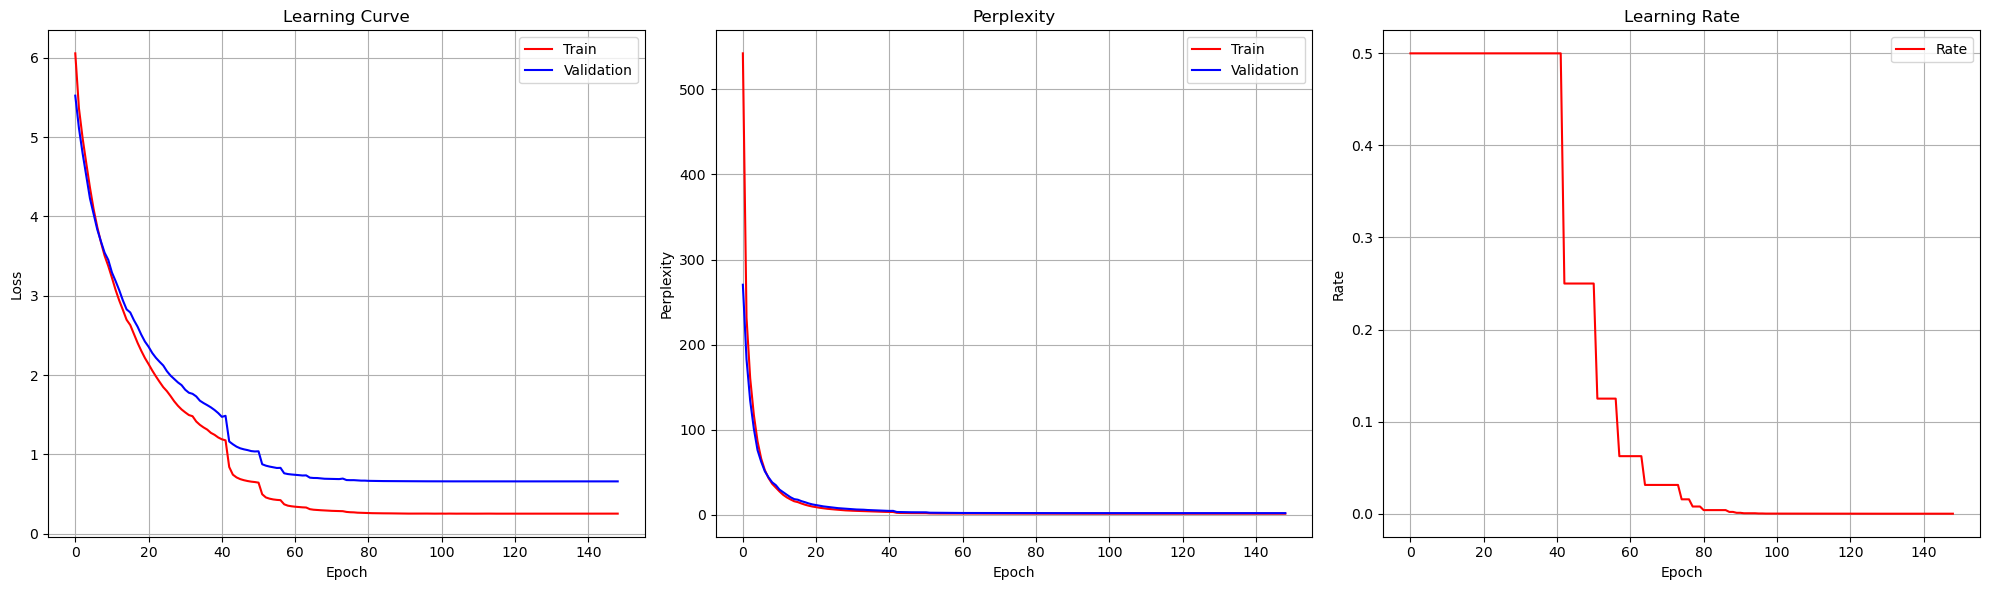

In [21]:
# Save as CSV
import pandas as pd
datas = {
    'epoch': range(epoch_counter),
    'loss_train': loss_train_hist,
    'loss_validation': loss_valid_hist,
    'perplexity_train': per_train_hist , 
    'perplexity_validation':per_valid_hist,
    'learning_rate': lr_train_hist
}
df = pd.DataFrame(datas)
df.to_csv("learningCurve.csv" , index=False)

fig, (ax1, ax2 , ax3) = plt.subplots(1, 3, figsize=(20, 6))

ax1.plot(range(epoch_counter), loss_train_hist, 'r-', label='Train')
ax1.plot(range(epoch_counter), loss_valid_hist, 'b-', label='Validation')
ax1.set_title('Learning Curve')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.grid(True)
ax1.legend()

ax2.plot(range(epoch_counter), per_train_hist, 'r-', label='Train')
ax2.plot(range(epoch_counter), per_valid_hist, 'b-', label='Validation')
ax2.set_title('Perplexity')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Perplexity')
ax2.grid(True)
ax2.legend()

ax3.plot(range(epoch_counter), lr_train_hist, 'r-', label='Rate')
ax3.set_title('Learning Rate')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Rate')
ax3.grid(True)
ax3.legend()

plt.tight_layout()
plt.show()

## Test Perplexity

In [22]:
model_path = 'model.pt'
model = torch.load(model_path)
model = model.to(device)
model.eval()

loss_fn = nn.CrossEntropyLoss()
perp = Perplexity().to(device)

loss_valid , per_valid  = evaluate(model, valid_loader, loss_fn , perp )
print(f"Validation: Loss = {loss_valid:.4} , Perplexity = {per_valid:.4}")

loss_test , per_test  = evaluate(model, test_loader, loss_fn , perp)
print(f"Test: Loss = {loss_test:.4} , Perplexity = {per_test:.4}")

/tmp/ipykernel_4679/1059837893.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(input), torch.tensor(target)


Validation: Loss = 0.6601 , Perplexity = 1.964
Test: Loss = 0.5712 , Perplexity = 1.782


# Text Generation

In [12]:
loss_fn = nn.CrossEntropyLoss()

model_path = 'model.pt'
model = torch.load(model_path,map_location='cuda')
#model = model.to('cuda')
model.eval()
model

H_LSTM(
  (embedding): Embedding(10000, 500)
  (dropout_em): Dropout(p=0.1, inplace=False)
  (rnn1): LSTM(500, 500, batch_first=True)
  (dropout1): Dropout(p=0.25, inplace=False)
  (rnn2): LSTM(500, 500, batch_first=True)
  (dropout2): Dropout(p=0.25, inplace=False)
  (rnn3): LSTM(500, 500, batch_first=True)
  (dropout3): Dropout(p=0.25, inplace=False)
  (fc): Linear(in_features=500, out_features=10000, bias=True)
)

In [13]:
num_trainable_params(model)

16.022

/tmp/ipykernel_20870/1059837893.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(input), torch.tensor(target)


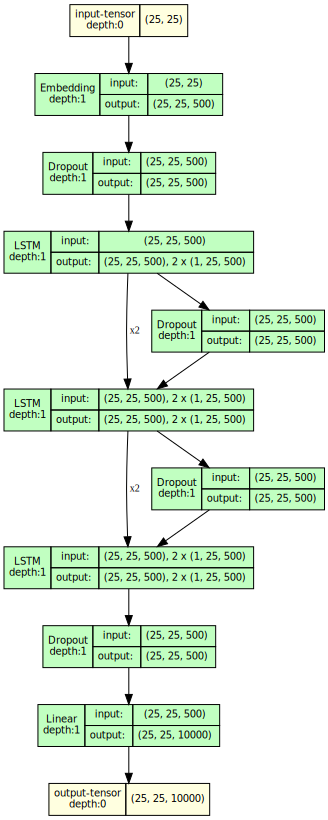

In [ ]:
from torchview import draw_graph
inputs, targets = next(iter(valid_loader)) # 
model_graph = draw_graph(model, input_data=inputs ,expand_nested=True)
model_graph.visual_graph

In [33]:
def generate(prompt, max_seq_len, temperature, model ):

    global device
    global vocab_itos
    global seq_len
    global char2ind
    
    prompt_tokens = prompt.split(' ')
    prompt_tokens = [char2ind[token] for token in prompt_tokens]  

    with torch.no_grad():
        current_token = torch.tensor(prompt_tokens).unsqueeze(0) 
        current_token = current_token.to(device)
        generated_text = prompt  
        for i in range(max_seq_len):
            output = model(current_token)
            probabilities = nn.functional.softmax(output[:, -1, :] / temperature, dim=-1)
            next_word = "<unk>"
            while next_word == "<unk>":
                next_token_id = torch.multinomial(probabilities, 1).item()
                next_word = findWordByToken(next_token_id)
            
            generated_text += " " + next_word

            next_token_id = torch.tensor([[next_token_id]]).to(device)
            if current_token.shape[1] < seq_len:
                current_token = torch.cat( ( current_token  , next_token_id ), dim=1)
            else:
                current_token = torch.cat( ( current_token[:, 1:]  , next_token_id ), dim=1)
            if next_word in ["<eos>", "."]:
                break
            del next_token_id
    return generated_text

prompt = "i think the movie"
generated_text = generate(prompt, 
                          max_seq_len = 100, 
                          temperature = 0.5, 
                          model = model)

print(generated_text)

i think the movie to come from anything to the workers 
 ryder also found the moving day traders said it can resume they slightly more than the same time 
 we 're n't expected to be being done in the market 
 the company said it is still going to post profits on the company 's financial debt 
 the company is expected to be taken because the company has n't given any time since the company 's management still have a strong profit in the earnings quarter 
 for the past several months the company has been a major real estate market
